In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
import gc

import fastai
from fastai.vision.all import *
from timm import create_model

import ipywidgets as widgets

from efficientnet_pytorch import EfficientNet

In [3]:
# https://frgfm.github.io/torch-cam/
import torchvision
from torchvision.io.image import read_image
from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image

In [4]:
SEED=42
BATCH_SIZE = 64

set_seed(SEED, reproducible=True)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [5]:
dataset_path = Path('../input/MMU2/')

In [6]:
fnames = get_image_files(dataset_path)

In [7]:
def label_func(x): return x.parent.name

In [8]:
dls = ImageDataLoaders.from_path_func(dataset_path, 
                                      fnames, 
                                      label_func,
                                      seed=SEED,
                                      bs=BATCH_SIZE,
                                      num_workers=8,
                                      item_tfms=[Resize((460), method=ResizeMethod.Crop)], #pass in item_tfms
                                      batch_tfms=aug_transforms(size=224, min_scale=0.75)) #pass in batch_tfms

In [9]:
dls.c

100

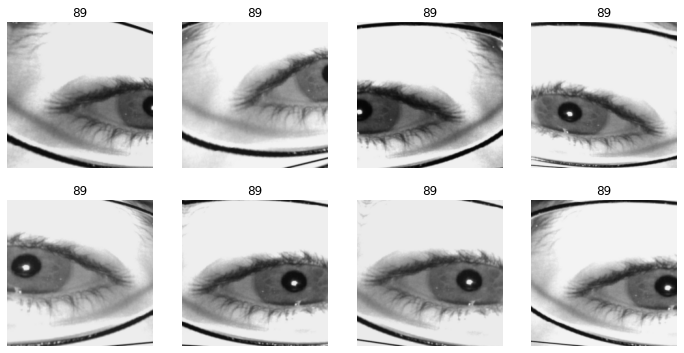

In [10]:
dls.show_batch(max_n=8, nrows=2, unique=True)

In [11]:
learn = cnn_learner(dls, 
                    resnet50, 
                    loss_func=LabelSmoothingCrossEntropyFlat(),
                    opt_func=ranger,
                    metrics=[error_rate,accuracy])

SuggestedLRs(valley=0.0020892962347716093)

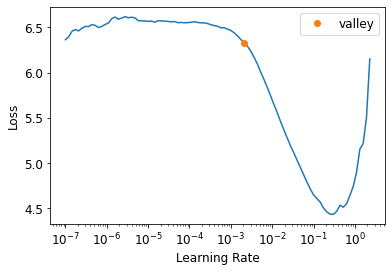

In [12]:
learn.lr_find()

In [12]:
learn.fine_tune(epochs=3,
                freeze_epochs=3,
                base_lr=3e-2,
                pct_start = 0.1,
                div=10,
                div_final = 30,
                wd=5e-3,
                moms=(0.9, 0.8,0.0), # quivalent to the Adam optimizer’s (beta_2, beta_1)
                cbs = [
                       SaveModelCallback(fname=f'best_model',monitor='valid_loss'),
                       EarlyStoppingCallback(monitor='valid_loss', comp=np.less, patience=5),
                       ReduceLROnPlateau(monitor='valid_loss', 
                                         min_delta=0.1, 
                                         patience = 3, 
                                         min_lr = 1e-8)]) 

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.750561,4.074147,0.879397,0.120603,00:05
1,3.966552,2.068729,0.386935,0.613065,00:05
2,3.095074,1.416369,0.140704,0.859297,00:05


Better model found at epoch 0 with valid_loss value: 4.0741472244262695.
Better model found at epoch 1 with valid_loss value: 2.0687291622161865.
Better model found at epoch 2 with valid_loss value: 1.4163689613342285.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.737286,1.420418,0.145729,0.854271,00:06
1,1.784475,1.285326,0.055276,0.944724,00:06
2,1.579491,1.172852,0.035176,0.964824,00:06


Better model found at epoch 0 with valid_loss value: 1.4204182624816895.
Better model found at epoch 1 with valid_loss value: 1.285326361656189.
Better model found at epoch 2 with valid_loss value: 1.1728521585464478.


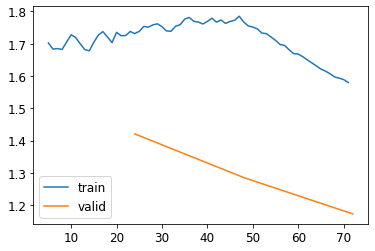

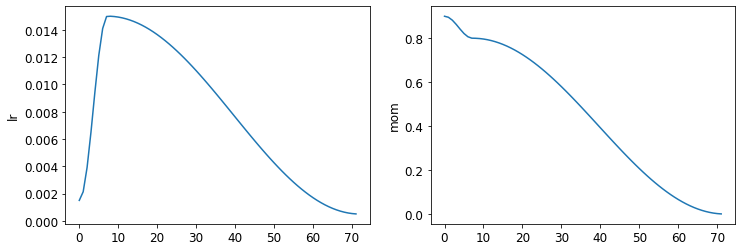

In [13]:
learn.recorder.plot_loss()
# schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_sched()

In [13]:
learn.load('best_model')
learn = learn.to_fp32()
learn.save('model_resnet50_1.000')

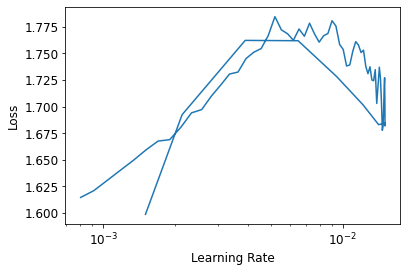

In [16]:
learn.recorder.plot_lr_find()

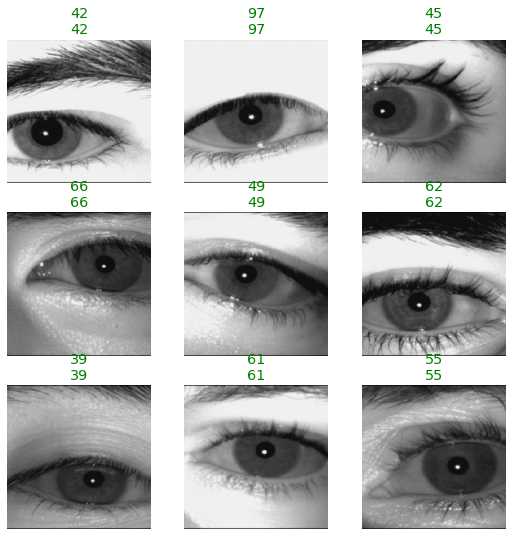

In [17]:
learn.show_results()

In [13]:
# learn.export(f'./models/model_resnet50_1.000.pkl')
# learn.export(f'model_resnet50_1.000')
learn.load('resnet50').eval()

In [14]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [15]:
img = PILImage.create(btn_upload.data[-1])

In [16]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:display(img.to_thumb(356,356))
out_pl

Output()

In [17]:
pred, pred_idx, probs = learn.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: 1; Probability: 0.9954')

In [18]:
pred

'1'

In [12]:
cam_extractor = SmoothGradCAMpp(learn.model)

In [15]:
model = learn.model

In [16]:
# Get your input
img = torchvision.io.image.read_image('../input/MMU2/1/010101.jpg') # 
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))

In [18]:
# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))

# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

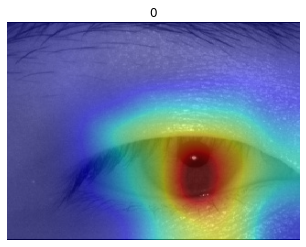

In [19]:
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam, mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

In [25]:
model2 = resnet50(pretrained=True)

In [26]:
model2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model, ["1", "7", "8"])

ValueError: Unable to find all submodules ['1', '7', '8'] in the model

In [ ]:


# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [ ]:
# This time, there are several CAMs
for cam in cams:
  print(cam.shape)

In [ ]:
# The raw CAM
_, axes = plt.subplots(1, len(cam_extractor.target_names))
for idx, name, cam in zip(range(len(cam_extractor.target_names)), cam_extractor.target_names, cams):
  axes[idx].imshow(cam.numpy()); axes[idx].axis('off'); axes[idx].set_title(name);
plt.show()

In [ ]:
# Let's fuse them
fused_cam = cam_extractor.fuse_cams(cams)
# Plot the raw version
plt.imshow(fused_cam.numpy()); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()
# Plot the overlayed version
result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()

## Clean Up

In [ ]:
# Once you're finished, clear the hooks on your model
cam_extractor.clear_hooks()

In [ ]:
del learn, model

torch.cuda.empty_cache()

gc.collect()